In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, classification_report
from sklearn.pipeline import Pipeline
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import keras_tuner as kt
from keras_tuner import RandomSearch
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import skew, kurtosis, randint
from sklearn.model_selection import RandomizedSearchCV

In [7]:
#creating dataframe
df = pd.read_csv('dataframe.csv')
df.head()

,Accuracy (%),Reaction Time (s),Cluster
0,78.2,2.45,0
1,85.6,2.30,1
2,91.0,2.18,1
3,73.5,2.60,0
4,88.9,2.25,1


In [5]:
#data preprocessing...
X = df.drop(columns=['Cluster'])
y = df['Cluster']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [8]:
#separating training and test data
X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns)
display(X_scaled_df.head())

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)

,Accuracy (%),Reaction Time (s)
0,-1.039923,0.797937
1,0.157809,-0.215316
2,1.031831,-1.025919
3,-1.800646,1.811191
4,0.691934,-0.553068


In [9]:
#Showing statistical features on Data
stats = pd.DataFrame({
    'Count': df.count(),
    'Mean': df.mean(),
    'Median': df.median(),
    'Std Dev': df.std(),
    'Variance': df.var(),
    'Min': df.min(),
    '25%': df.quantile(0.25),
    '50%': df.quantile(0.5),
    '75%': df.quantile(0.75),
    'Max': df.max(),
    'Skewness': df.apply(skew)
})

display(stats.style.format("{:.3f}").background_gradient(cmap='Blues'))

,Count,Mean,Median,Std Dev,Variance,Min,25%,50%,75%,Max,Skewness
Accuracy (%),16.000,84.625,84.750,6.381,40.717,73.500,79.400,84.750,89.900,94.100,-0.103
Reaction Time (s),16.000,2.332,2.315,0.153,0.023,2.100,2.215,2.315,2.458,2.600,0.187
Cluster,16.000,0.500,0.500,0.516,0.267,0.000,0.000,0.500,1.000,1.000,0.000


,Mean,Standard Deviation,Variance,Skewness
Accuracy (%),84.625000,6.380961,40.716667,-0.103368
Reaction Time (s),2.331875,0.152893,0.023376,0.187455
Cluster,0.500000,0.516398,0.266667,0.000000


In [ ]:
#Neural Network

def build_model(hp):
    model = keras.Sequential()

    # First layer (input layer + first hidden layer)
    model.add(layers.Dense(
        units=hp.Int('units_0', min_value=32, max_value=256, step=32),
        activation='relu',
        input_shape=(X_train.shape[1],)
    ))
    for i in range(hp.Int('num_layers', 1, 3)):
      model.add(layers.Dense(
        units=hp.Int(f'units_{i+1}', min_value=32, max_value=256, step=32),
        activation='relu'
      ))
    model.add(layers.Dense(len(np.unique(y)), activation='softmax'))

    model.compile(
    optimizer=keras.optimizers.Adam(
        hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4])
    ),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
    )
    return model


In [ ]:
# Run the tuner
tuner.search(X_train, y_train, epochs=20, validation_split=0.2, verbose=1)

# Getting the best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
best_model = build_model(best_hps)

# Train the best model
best_model.fit(X_train, y_train, epochs=30, validation_split=0.2, verbose=1)

Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.0000e+00 - loss: 0.7210 - val_accuracy: 1.0000 - val_loss: 0.6711
Epoch 2/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - accuracy: 1.0000 - loss: 0.6756 - val_accuracy: 1.0000 - val_loss: 0.6264
Epoch 3/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 1.0000 - loss: 0.6414 - val_accuracy: 1.0000 - val_loss: 0.5878
Epoch 4/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 1.0000 - loss: 0.6098 - val_accuracy: 1.0000 - val_loss: 0.5513
Epoch 5/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 1.0000 - loss: 0.5793 - val_accuracy: 1.0000 - val_loss: 0.5131
Epoch 6/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 1.0000 - loss: 0.5457 - val_accuracy: 1.0000 - val_loss: 0.4727
Epoch 7/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 1.0000 - loss: 0.5087 - val_accuracy: 1.0000 - val_loss: 0.4308
Epoch 8/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step - accuracy: 1.0000 - loss: 0.4685 - val_accuracy: 1.0000 - val_loss: 0.3886
Epoch 9/

In [ ]:
#Predicting...
y_pred = best_model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)  # Converting probabilities to class labels
accuracy_score(y_test, y_pred)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


1.0

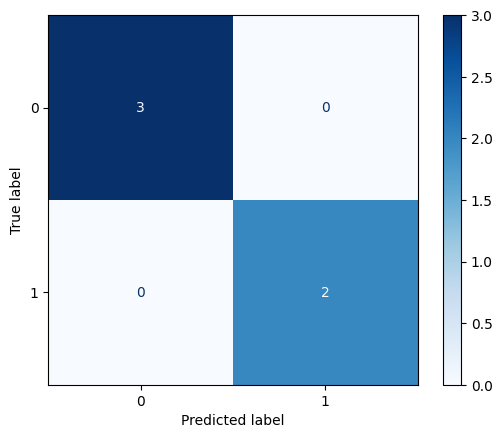

In [ ]:
#plotting confusion matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.show()


In [ ]:
#Random Forest

#Tuning parameters using RandomSearch.
rf = RandomForestClassifier(random_state=42)

param_distributions = {
    'n_estimators': [50, 100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

random_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_distributions,
    n_iter=20,
    cv=5,
    random_state=42,
    verbose=1,
    n_jobs=-1
)

random_search.fit(X_train, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
                   n_iter=20, n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [None, 10, 20, 30],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [50, 100, 200, 300]},
                   random_state=42, verbose=1)

In [ ]:
#training with best parameters found
best_params = random_search.best_params_

best_rf = RandomForestClassifier(**best_params, random_state=42)
best_rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=False, min_samples_leaf=2, random_state=42)

In [ ]:
# Predicting...
y_pred = best_rf.predict(X_test)
accuracy_score(y_test, y_pred)

0.8

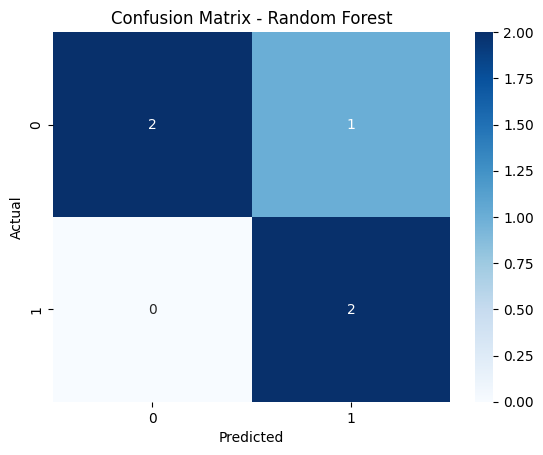

In [ ]:
# Confusion Matrix for Random Forest
cm_rf = confusion_matrix(y_test, y_pred_rf)

sns.heatmap(cm_rf, annot=True, fmt='d', cmap="Blues")
plt.title("Confusion Matrix - Random Forest")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


In [ ]:
#Training XgBoost
from xgboost import XGBClassifier

xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
xgb_model.fit(X_train, y_train)


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [09:26:19] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, ...)

In [ ]:
#Predicting
y_pred_xgb = xgb_model.predict(X_test)
accuracy_score(y_test, y_pred_xgb)

0.8

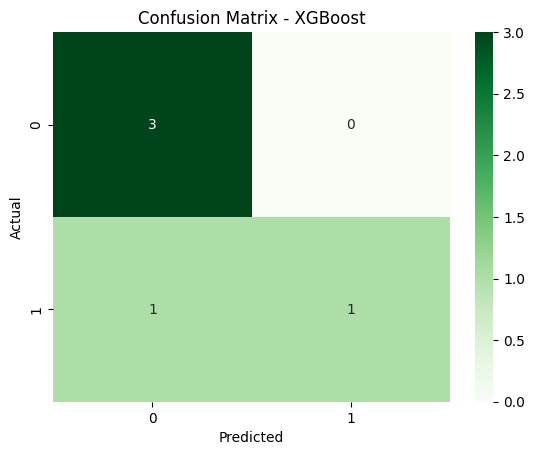

In [ ]:
# Confusion Matrix
cm_xgb = confusion_matrix(y_test, y_pred_xgb)

sns.heatmap(cm_xgb, annot=True, fmt='d', cmap="Greens")
plt.title("Confusion Matrix - XGBoost")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()